# DSOSD: Robust loss-based dynamic seizure onset and spread detection

In [18]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

In [19]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [20]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))
###########################
prodatapath = prodatapath # This is the path to where the pkl files i've sent
figpath = figpath         # This is the path to where you want saved figures to be stored

In [21]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

## Minimally supervised seizure detection

#### Loading and preparing data

In [22]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice.pkl"))

In [23]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [24]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.00,[],[],[],...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.000000,0.000000,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.00,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.000000,0.000000,ueo_consensus_strict_dice,0.000000
1,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,0.00,[],[],[],...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.000000,0.000000,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.00,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.000000,0.000000,ueo_consensus_strict_dice,0.000000
2,CHOP005,CHOP005,NRG,1.0,68881.53,68881.53,0.00,[],[],[],...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.000000,0.000000,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.00,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.000000,0.000000,ueo_consensus_strict_dice,0.000000
3,CHOP005,CHOP005,WVNT,1.0,68881.53,68881.53,0.00,[],[],[],...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.000000,0.000000,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.00,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.000000,0.000000,ueo_consensus_strict_dice,0.000000
4,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.01,"[LK02, LK04, LK05, LK06, LK07, LK08, LL01, LL0...","[LA03, LA04, LB01, LB02, LB06, LB07, LD01, LD0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.173913,0.163934,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.16,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.383562,0.363636,ueo_consensus_strict_dice,0.090909


#### Plotting optimal threshold performance

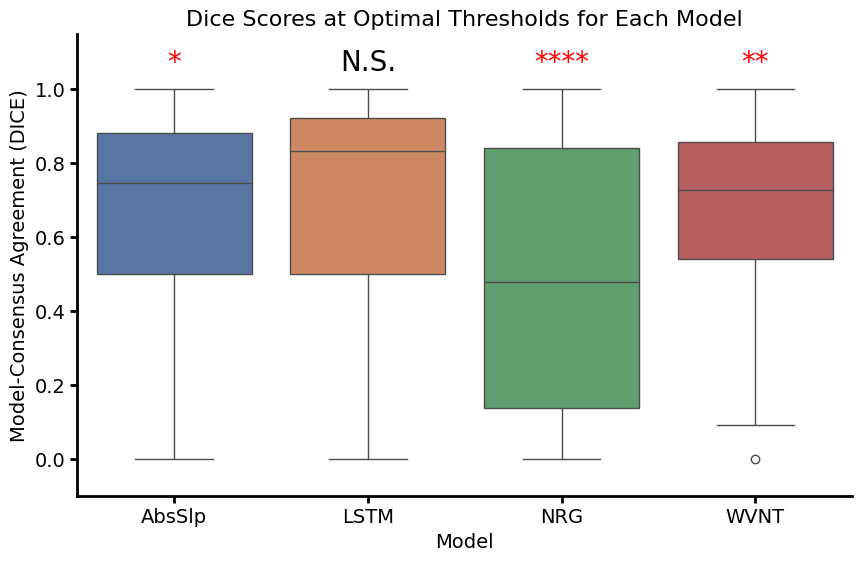

In [25]:
optimal_thresholds = mdl_preds_long.loc[mdl_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset"]]
# Step 2: Create a box plot of dice scores at optimal thresholds for each model
plt.figure(figsize=(10, 6))
sns.boxplot(data=optimal_thresholds, x='model', y='dice',palette='deep')
plt.title('Dice Scores at Optimal Thresholds for Each Model')
plt.xlabel('Model')
plt.ylabel('Model-Consensus Agreement (DICE)')
sns.despine()
sigs = ['*','N.S.','****','**']
cols = ["red","black","red","red"]
for i in range(4):
    plt.text(i,1.05,sigs[i],fontsize=20,color=cols[i],ha='center')
plt.ylim([-.1,1.15])
plt.show()



#### Comparing to clinician consensus

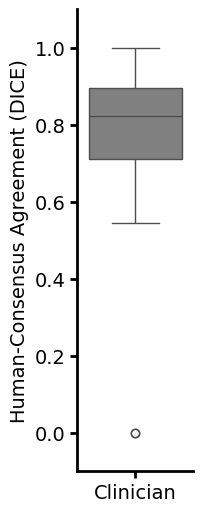

In [27]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'stim_seizure_information_consensus.pkl'))
for i_r, row in consensus_annots.iterrows():
    annot_sets = row.ueo
    die = 0
    for annot in annot_sets:
        die += f1_score(annot,row.ueo_consensus)
    consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(consensus_annots,y='f1',color='grey')
plt.xticks([0],['Clinician'])
plt.ylabel('Human-Consensus Agreement (DICE)')
plt.ylim([-.1,1.1])
sns.despine()

In [28]:
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_thresholds[optimal_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=2784.5, pvalue=0.02402136977165458)
LSTM
MannwhitneyuResult(statistic=2455.5, pvalue=0.4196895548527131)
NRG
MannwhitneyuResult(statistic=3240.0, pvalue=1.9580472995471307e-05)
WVNT
MannwhitneyuResult(statistic=2934.0, pvalue=0.0035498669940546594)


#### Combining model and clinician annotations

In [29]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
optimal_thresholds['patient'] = optimal_thresholds['Patient']
optimal_thresholds.drop('Patient',axis=1,inplace=True)
all_plot_agreements = pd.concat([optimal_thresholds,consensus_annots[["patient","stim","approximate_onset","model","dice"]]])

Text(0.5, 1.0, 'Suppervised Annotation')

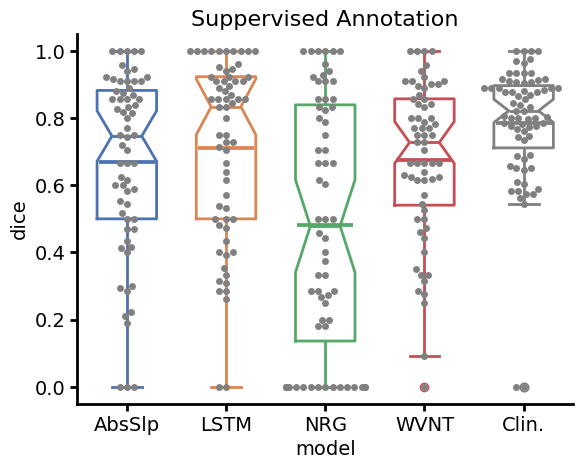

In [30]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Suppervised Annotation")

## Customizing plots

#### No Chop

In [31]:
all_plot_agreements_nochop = all_plot_agreements[all_plot_agreements.patient.apply(lambda x: 'HUP' in x)]

Stats comparing models to clinician
AbsSlp
MannwhitneyuResult(statistic=1562.5, pvalue=0.17197218206543363)
LSTM
MannwhitneyuResult(statistic=1304.0, pvalue=0.7571404595781034)
NRG
MannwhitneyuResult(statistic=1845.0, pvalue=0.001342567053537083)
WVNT
MannwhitneyuResult(statistic=1683.0, pvalue=0.03159414807331248)


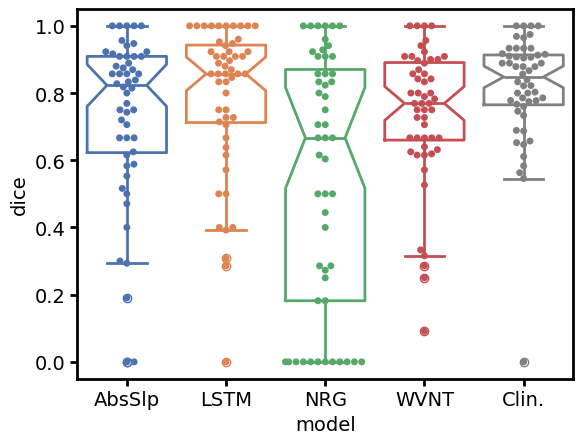

In [32]:
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements_nochop,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]),fill=False,notch=True)
sns.swarmplot(all_plot_agreements_nochop,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = all_plot_agreements_nochop
print("Stats comparing models to clinician")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

#### No stim

Stats comparing models to clinicians
AbsSlp
MannwhitneyuResult(statistic=748.5, pvalue=0.4921305843520749)
LSTM
MannwhitneyuResult(statistic=670.0, pvalue=0.8795195945439538)
NRG
MannwhitneyuResult(statistic=840.5, pvalue=0.09225393025892936)
WVNT
MannwhitneyuResult(statistic=860.0, pvalue=0.05834113195081058)


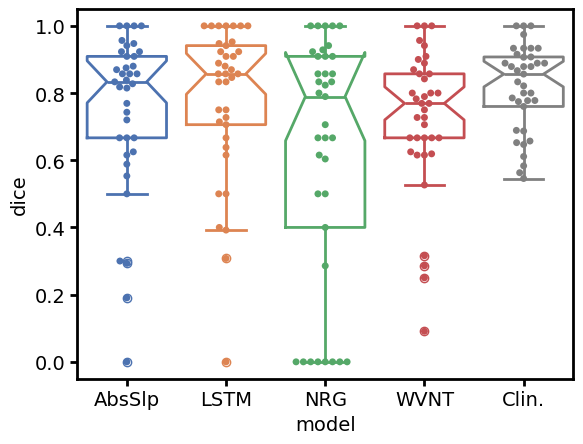

In [33]:
all_plot_agreements_nostim = all_plot_agreements_nochop[all_plot_agreements_nochop.stim == 0]
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements_nostim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]),notch=True,fill=False)
sns.swarmplot(all_plot_agreements_nostim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = all_plot_agreements_nostim
print("Stats comparing models to clinicians")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

#### Only Stim

Stats comparing models to clinicians
AbsSlp
MannwhitneyuResult(statistic=149.0, pvalue=0.13520822290510115)
LSTM
MannwhitneyuResult(statistic=106.5, pvalue=0.8193084753396667)
NRG
MannwhitneyuResult(statistic=185.5, pvalue=0.0025736413767037513)
WVNT
MannwhitneyuResult(statistic=135.5, pvalue=0.3505267202452744)


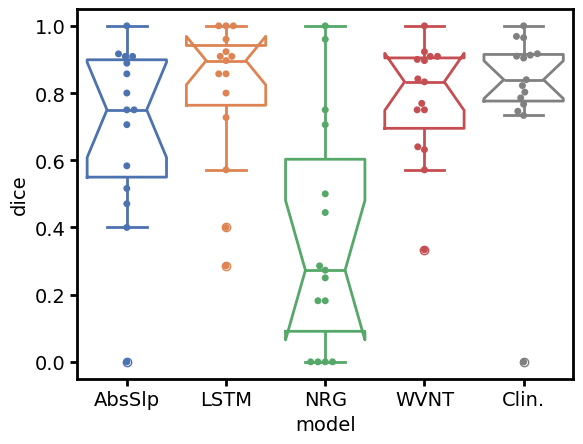

In [40]:
all_plot_agreements_stim = all_plot_agreements_nochop[all_plot_agreements_nochop.stim == 1]
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements_stim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]),notch=True,fill=False)
sns.swarmplot(all_plot_agreements_stim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = all_plot_agreements_nostim
print("Stats comparing models to clinicians")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

## Patient Level

You can change the plotting dataframe to any of the others from above and plot the distributions grouped by patient

Stats comparing models to clinicians
AbsSlp
MannwhitneyuResult(statistic=149.0, pvalue=0.13520822290510115)
LSTM
MannwhitneyuResult(statistic=106.5, pvalue=0.8193084753396667)
NRG
MannwhitneyuResult(statistic=185.5, pvalue=0.0025736413767037513)
WVNT
MannwhitneyuResult(statistic=135.5, pvalue=0.3505267202452744)


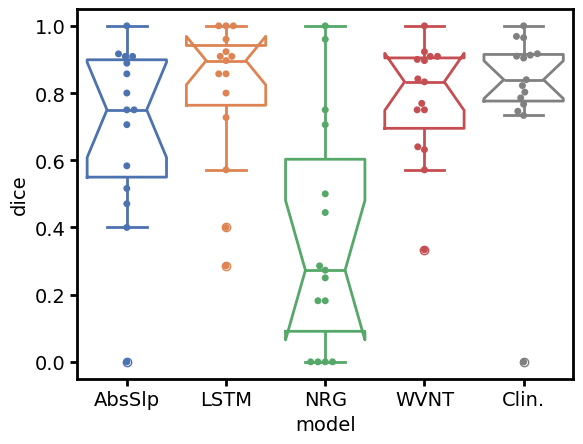

In [43]:
pt_plot_agreements = all_plot_agreements_nostim.groupby(['patient','model'])[['dice']].mean().reset_index()
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(pt_plot_agreements,x='model',y='dice',order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],palette = np.vstack([np.array(colors),[.5,.5,.5]]),notch=True,fill=False)
sns.swarmplot(pt_plot_agreements,x='model',y='dice',order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = pt_plot_agreements
print("Stats comparing models to clinicians")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

## KDE Model Predictions

#### Loading unsupervised detections

In [44]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[predicted_channels.stim == 0]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [45]:
pred_channels_wdice.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_loose_dice,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice
76,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.234222,"[LA06, LP02, LW01, LW07, LW08, LW10, LX01, RA0...","[LA06, LA07, LP02, LP03, LW01, LW02, LW07, LW0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,0.307692,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.444444,0.350000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.275000,0.235294,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.333333,0.301887
77,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,102.298576,[],[],[],...,0.000000,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.000000,0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.000000,0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.000000,0.000000
78,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.185835,"[RA01, RA02, RA05, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02, RA03, RA05, RA06, RB01, RB02, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.631579,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.750000,0.700000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.444444,0.436364,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.489796,0.508475
79,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,2.187550,"[LB01, LB02, LB03, LB05, LC01, RA01, RA05, RB0...","[LB01, LB02, LB03, LB04, LB05, LB06, LC01, LC0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.461538,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.600000,0.518519,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.454545,0.444444,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.500000,0.517241
128,HUP224,HUP224_phaseII,LSTM,0.0,491467.8046,491467.8046,1.856586,"[LA01, LB01, LB02, LB03, LB05, LC01, LC02, LC0...","[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...",...,0.324324,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.428571,0.368421,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.423077,0.380952,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.500000,0.477612


Text(31.763888888888886, 0.5, 'Agreement (DICE)')

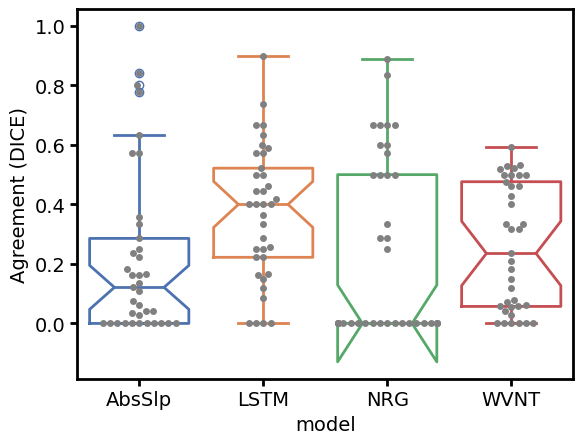

In [46]:
sns.boxplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',color='gray')
plt.ylabel("Agreement (DICE)")